In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp

import camb
from camb import model, initialpower

from numpy import linalg as LA
import utils
from utils import m_l as m_l
from utils import bin_l as bin_l

plt.rcParams['figure.figsize'] = (10.0, 8.0)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


# Function

In [2]:
def deconv(maps, beam_in, beam_out, lmax):
    ''' 
    Beam in unit of arc-miniute.
    This function changes the value of the input map itself.
    
    '''
    
    _maps = np.copy(maps)
    for j in range(1,3): ### only for Q\U;
        _maps[j] = hp.sphtfunc.decovlving(_maps[j], fwhm = beam_in/60/180*np.pi, lmax = lmax, verbose = False)
        _maps[j] = hp.smoothing(_maps[j], fwhm = beam_out/60/180*np.pi, lmax = lmax, verbose = False)
    return _maps


def smooth(maps, beam_out, lmax):
    _maps = np.copy(maps);
    for j in range(1,3):                        ###for Q and U. Exclude I.
        _maps[j] = hp.smoothing(_maps[j], fwhm = beam_out/60/180*np.pi, lmax = lmax, verbose = False)
    return _maps

# ali_ma = hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/Ali_mask_1024.fits'), nside_out = 512)#, verbose=False)
ali_ma = hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/ali_mask_wo_edge.fits'), nside_out = 512)
def Mask(maps): 
    maps_ma = hp.ma(maps)
    maps_ma.mask = np.logical_not(ali_ma)
    return maps_ma

def Power_spectrum(maps,R, lmax):
    ''' 
    revised for upper-triangle of the matrix.
    Input:
    maps with multi-frequencies IQU sky maps. 
    Galactic plane cut for calculating the power spectrum.
    lmax.  

    Return: EE and BB cross power spectrum. 
    Shape (2, lmax, nf, nf)
    '''
    n_f = len(maps)
    cl = np.ones((2, n_f*n_f, lmax +1)); Cl = np.zeros((2, lmax+1, n_f, n_f))
    k = 0
    for i in range(n_f):
        for j in range(n_f):
            
            if i >= j :
                cross_ps = hp.anafast(maps[i], maps[j], lmax = lmax, gal_cut=R, nspec=3) ## TT, EE, BB
            else:
                cross_ps = np.zeros((3, lmax+1)) 
            cl[0][k] = cross_ps[1]; cl[1][k] = cross_ps[2]  ## calculate the E and B_mode power spectrum 
            k += 1
            
    for l in range(lmax+1):
        Cl[0, l, : , :] = cl[0, :,l].reshape(n_f, n_f); Cl[1, l, : , :] = cl[1, :,l].reshape(n_f, n_f)
        Cl[0, l] += Cl[0, l].T - np.diag(Cl[0, l].diagonal()) ; Cl[1, l] += Cl[1, l].T - np.diag(Cl[1, l].diagonal()) 
    return Cl

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [3]:
fore95 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_observations_AliCPT/95GHz/group2_map_95GHz.fits', field = None, verbose = False), nside_out=512)  ### 19 arcmin, uK_CMB
### 11 arcmin, uK_CMB
fore150 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_observations_AliCPT/150GHz/group2_map_150GHz.fits', field = None, verbose = False), nside_out=512) 
 ###4.944 arcmin, K_CMB
fore353 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_observations_HFI_353/group2_map_detector_F353.fits', field = None, verbose = False), nside_out=512)*1e6

In [29]:
SamNum =100; lmax = 1000; Nf = 3
nside = 512
for i in range(SamNum):
    if i < 50:
        noise_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_realizations_95GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
        noise_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_realizations_150GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
    else: 
        noise_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_95GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
        noise_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_150GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
        
    noise_353 = 1e6*hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/353GHZ_PLA/noise_353_full_map_mc_%05d.fits'%i, field = None, verbose = False), nside_out=nside)
    
#     Noise = np.zeros((Nf,3,12*nside**2))
#     Noise[0] = noise_95;  
#     Noise[1] = deconv(noise_150, beam_in = 11, beam_out = 19, lmax = 1500); 
#     Noise[2] = deconv(noise_353, beam_in = 4.944, beam_out = 19, lmax = 1500);
#     noise_ps_i = utils.Power_spectrum(Mask(Noise), 0, lmax = lmax)
#     np.save('/fnx/jianyao/ancillary_data/noise_ps/nl_deconv_masked_EB_%s.npy'%i, noise_ps_i)
    
    cmb_i = hp.ud_grade(hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%(i), field = None, verbose = False), nside_out = 512)
    total = np.zeros((Nf, 3, 12*nside**2))
    total[0] = smooth(cmb_i, beam_out=19, lmax = 1500) + fore95 + noise_95
    total[1] = deconv(smooth(cmb_i, beam_out=11, lmax = 1500) + fore150 + noise_150, beam_in = 11, beam_out = 19, lmax = 1500)
    total[2] = deconv(smooth(cmb_i, beam_out=4.944, lmax = 1500) + fore353 + noise_353, beam_in = 4.944, beam_out = 19, lmax = 1500)
    total_mask = Mask(total)
    
    np.save('/fnx/jianyao/ancillary_data/total_map/total_masked%s.npy'%(n))
#     total_ps_i = utils.Power_spectrum(total_mask, 0, lmax = lmax)
#     np.save('/fnx/jianyao/ancillary_data/total_ps/total_ps_deconv_masked_EB_%s.npy'%i, total_ps_i)

In [24]:
cmb_clean_1 = hp.read_map('/fnx/jianyao/HS_clean_CMB/Cleaned_QU_069.fits', field = None)

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [25]:
cmb_clean_all = np.ones((3, 512**2*12))
cmb_clean_all[1] = cmb_clean_1[0]
cmb_clean_all[2] = cmb_clean_1[1]

In [26]:
cls = hp.anafast(cmb_clean_all, lmax = 999, nspec=3)

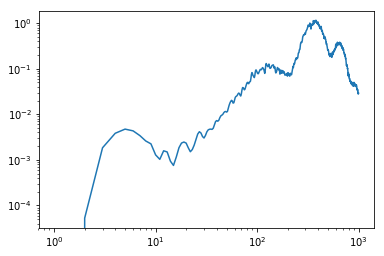

In [27]:
ell = np.arange(len(cls[0]))
plt.loglog(ell, ell*(ell+1)/2/np.pi*cls[1])

# CMB -- ILC bias

In [57]:
SamNum = 100; nside = 512; lmax = 1000

In [58]:
cross_cl = np.zeros((SamNum,3, lmax + 1))
for n in range(SamNum):
    
    cmb_i = hp.ud_grade(hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%(n), field = None, verbose = False), nside_out = 512)
    cmb_ma = Mask(smooth((cmb_i), beam_out=19, lmax = 1500))
    
    cmb_i = np.zeros(12*nside**2)
    
    cmb_cleaned = Mask(np.row_stack((cmb_i, hp.read_map('/fnx/jianyao/HS_clean_CMB/Cleaned_QU_%03d.fits'%(n), field = None, verbose = False))))
    
    cross_cl[n] = hp.anafast(cmb_ma, cmb_ma - cmb_cleaned, lmax = 1000, nspec=3)
    

In [61]:
cross_mean = np.mean(cross_cl, axis=0)

In [73]:
cross_mean_EE = bin_l(cross_mean[1], L = 1000, Q = 50)
cross_mean_BB = bin_l(cross_mean[2], L = 1000, Q = 50)

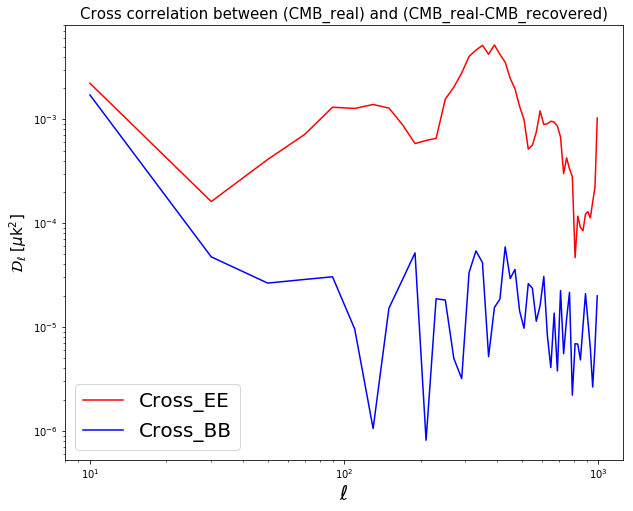

In [81]:
plt.figure(figsize = (10, 8))
Ell = utils.get_ell(1000, 50)
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*(cross_mean_EE), 'r-', label = 'Cross_EE')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*abs(cross_mean_BB), 'b-', label = 'Cross_BB')

plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 15)
plt.legend(fontsize = 20)
plt.title('Cross correlation between (CMB_real) and (CMB_real-CMB_recovered)', fontsize = 15)
plt.savefig('/home/jianyao/Ali_maps/results/0221_ILC_pixel/cross_ILC_bias.png', format = 'png')

# cross with foreground

In [100]:
Nf = 3; nside = 2048

In [101]:
sync = np.zeros((Nf, 3, 12*nside**2)); dust = np.zeros((Nf, 3, 12*nside**2)); noise = np.zeros((Nf, 3, 12*nside**2))
# uK_CMB, nside = 2048
sync[0] = hp.read_map('/fnx/jianyao/1205_skyinband_AliCPT/95GHz/synchrotron_map_95GHz.fits', field = (0,1,2), verbose = False)

dust[0] = hp.read_map('/fnx/jianyao/1205_skyinband_AliCPT/95GHz/thermaldust_map_95GHz.fits', field = (0,1,2), verbose = False)

sync[1] = hp.read_map('/fnx/jianyao/1205_skyinband_AliCPT/150GHz/synchrotron_map_150GHz.fits', field = None, verbose = False)
dust[1] = hp.read_map('/fnx/jianyao/1205_skyinband_AliCPT/150GHz/thermaldust_map_150GHz.fits', field = None, verbose = False)

#K_CMB, 2048
sync[2] = hp.read_map('/fnx/jianyao/1205_skyinband_HFI_353/detector_F353/synchrotron_map_detector_F353.fits', field = (0,1,2), verbose = False)*1e6 
dust[2] = hp.read_map('/fnx/jianyao/1205_skyinband_HFI_353/detector_F353/thermaldust_map_detector_F353.fits', field = None, verbose = False)*1e6

In [93]:
cl_camb = np.loadtxt('./cls_r_0p05.txt')

In [205]:
## 2048, K_CMB

noise[0] = 1e6*hp.read_map('/fnx/jianyao/Noise_realizations/100GHz_PLA/noise_100_full_map_mc_%05d.fits'%0, field = None, verbose = False)
noise[1] = 1e6*hp.read_map('/fnx/jianyao/Noise_realizations/143GHz_PLA/noise_143_full_map_mc_%05d.fits'%0, field = None, verbose = False)
noise[2] = 1e6*hp.read_map('/fnx/jianyao/Noise_realizations/353GHZ_PLA/noise_353_full_map_mc_%05d.fits'%0, field = None, verbose = False)

In [226]:
len(noise[0,0])

50331648

In [227]:
len(sync[2,0])

50331648

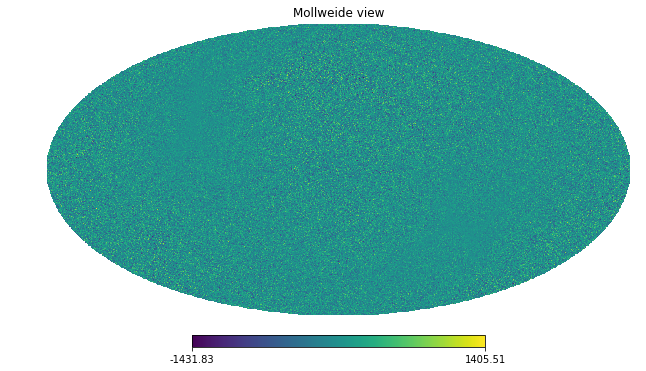

In [213]:
hp.mollview(noise[2][1])

In [236]:
cmb_i =  hp.synfast(cl_camb, nside = 2048, verbose = False, new = True)

In [154]:
lmax = 2048
m_num = int((2 + lmax)*(lmax+1)/2)

In [182]:
alm_all = np.zeros((3, 4, 3, m_num), dtype = 'complex128')

In [209]:
for i in range(3):
    
    alm_all[i][0] = alm_cmb;
    alm_all[i][1] = hp.map2alm(sync[i], lmax = nside);
    alm_all[i][2] = hp.map2alm(dust[i], lmax = nside);
    alm_all[i][3] = hp.map2alm(noise[i], lmax = nside);

In [105]:
alm_cmb = hp.map2alm(cmb_i, lmax = nside)

In [210]:
np.save('Alms_all.npy', alm_all)

In [211]:
alms_total = np.load('Alms_all.npy')

In [189]:
cmb_re = hp.alm2map(alms_total[0][0], nside = 2048, lmax = 2048)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


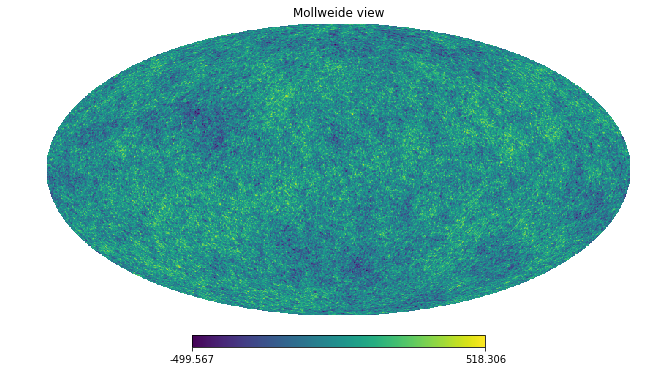

In [190]:
hp.mollview(cmb_re[0])

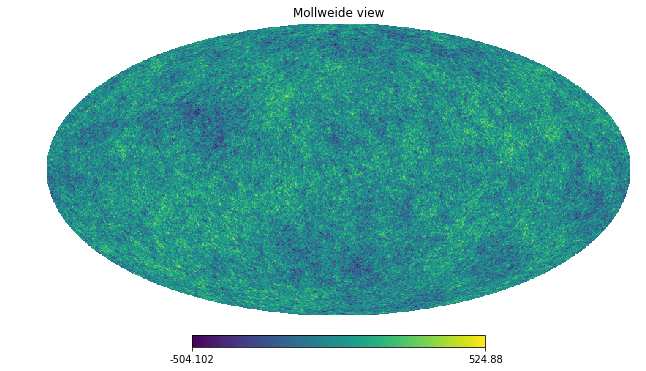

In [188]:
hp.mollview(cmb_i[0])

In [194]:
alm1 = hp.map2alm(cmb_i[0])

In [195]:
cmb_rl = hp.alm2map(alm1, nside = 2048)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


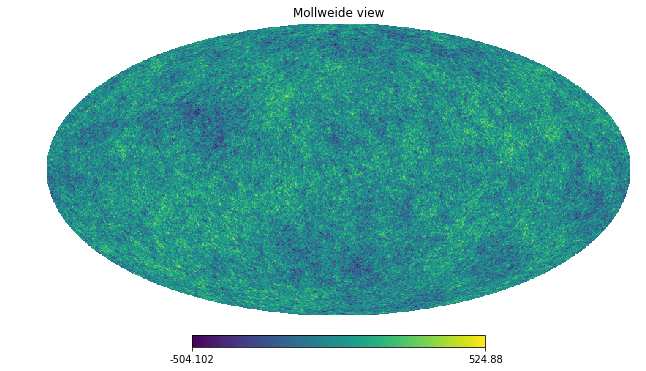

In [196]:
hp.mollview(cmb_rl)

In [214]:
total_map = sync + dust

In [215]:
total_map[0] += cmb_i;
total_map[1] += cmb_i;
total_map[2] += cmb_i;

In [216]:
total_ps = utils.Power_spectrum(total_map,0,1000)

In [220]:
total_ps.shape

(2, 1001, 3, 3)

# Plot for all

In [221]:
# 13.0765 arcmin, K_CMB
fore70 = hp.read_map('/fnx/jianyao/LFI_070/group2_map_detector_F070.fits', field = None, verbose = False)*1e6

#27.9435 arcmin, K_CMB
fore44 = hp.read_map('/fnx/jianyao/LFI_044/group2_map_detector_F044.fits', field = None, verbose = False)*1e6

### 19 arcmin, uK_CMB
fore95 = hp.read_map('/fnx/jianyao/1205_observations_AliCPT/95GHz/group2_map_95GHz.fits', field = None, verbose = False) 
### 11 arcmin, uK_CMB
fore150 = hp.read_map('/fnx/jianyao/1205_observations_AliCPT/150GHz/group2_map_150GHz.fits', field = None, verbose = False)
 ###4.944 arcmin, K_CMB
fore353 = hp.read_map('/fnx/jianyao/1205_observations_HFI_353/group2_map_detector_F353.fits', field = None, verbose = False)*1e6

In [234]:
i = 1

noise_95 = hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_95GHz_50_2048.fits', field = None, verbose = False)
noise_150 = hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_150GHz_50_2048.fits', field = None, verbose = False)

# # K_CMB, nside = 1024, IQU
# noise_70 = 1e6*hp.read_map('/fnx/jianyao/Noise_realizations/70GHz_LFI/70GHz_LFI_noise_070_full_map_mc_%05d.fits'%i, field = None, verbose = False)
# noise_44 = 1e6*hp.read_map('/fnx/jianyao/Noise_realizations/44GHz_LFI/noise_044_full_map_mc_%05d.fits'%i, field = None, verbose = False)

#K_CMB, 2048
noise_353 = 1e6*hp.read_map('/fnx/jianyao/Noise_realizations/353GHZ_PLA/noise_353_full_map_mc_%05d.fits'%i, field = None, verbose = False)
    

In [237]:
total_95 = smooth(cmb_i, beam_out = 19, lmax = 2000) + fore95 + noise_95
total_150 = smooth(cmb_i, beam_out = 11, lmax = 2000) + fore150 + noise_150
total_353 = smooth(cmb_i, beam_out = 4.944, lmax = 2000) + fore353 + noise_353

In [238]:
tcl_95 = hp.anafast(Mask(total_95), nspec = 3, lmax = 2000); fcl95 = hp.anafast(Mask(fore95), nspec = 3, lmax = 2000);
tcl_150 = hp.anafast(Mask(total_150), nspec = 3, lmax = 2000);fcl150 = hp.anafast(Mask(fore150), nspec = 3, lmax = 2000);
tcl_353 = hp.anafast(Mask(total_353), nspec = 3, lmax = 2000);fcl353 = hp.anafast(Mask(fore353), nspec = 3, lmax = 2000);

In [ ]:
nl95 = hp.anafast(Mask(noise_95), nspec = 3, lmax = 2000); cmb_95 = hp.anafast(Mask(smooth(cmb_i, beam_out = 19, lmax = 2000)))
nl150 = hp.anafast(Mask(noise_150), nspec = 3, lmax = 2000); cmb_150 = hp.anafast(Mask(smooth(cmb_i, beam_out = 11, lmax = 2000)))
nl353 = hp.anafast(Mask(noise_353), nspec = 3, lmax = 2000); cmb_353 = hp.anafast(Mask(smooth(cmb_i, beam_out = 4.944, lmax = 2000)))

In [ ]:
ell = utils.get_ell(2000, 2000)
el2 = utils.l2(ell)

In [ ]:
plt.loglog(ell, el2*tcl_95)
plt.loglog(ell, el2*fcl95)
plt.loglog(ell, el2*nl_95)
plt.loglog(ell, cmb_95*el2)